# <span style="color:#336699">SER-347 - Introdução à Programação para Sensoriamento Remoto</span>
<hr style="border:2px solid #0077b9;">

# <span style="color:#336699">GDAL - Parte 3</span>

[<img src="http://gdal.org/gdalicon.png" alt="GDAL" align="right">](http://gdal.org)

Professores:
- Thales Sehn Körting
- Gilberto Ribeiro de Queiroz

Passos necessários para manipular imagens:
* importar bibliotecas (GDAL, NumPy, matplotlib, etc.)
* definir o caminho correto dos arquivos raster
* abrir um dataset para cada arquivo
* verificar compatibilidade dos metadados
* obter as bandas de cada raster
* converter as bandas para matrizes no formato NumPy
* manipular números digitais presentes nas matrizes
* (se necessário) salvar as informações em um novo arquivo raster

In [1]:
# importar bibliotecas
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import sys

# importar constantes
from gdalconst import *

# informar o uso de exceções
gdal.UseExceptions()

## Exercício

Abrir duas imagens (crop-1-band-5.tif e crop-1-band-7.tif), realizar uma aritmética de bandas (usar NDVI), aplicar um threshold (fatiamento - NDVI > 0.5). Apresentar na tela uma visualização dos pixels da banda 7 que correspondem ao critério do fatiamento (NDVI > 0.5).

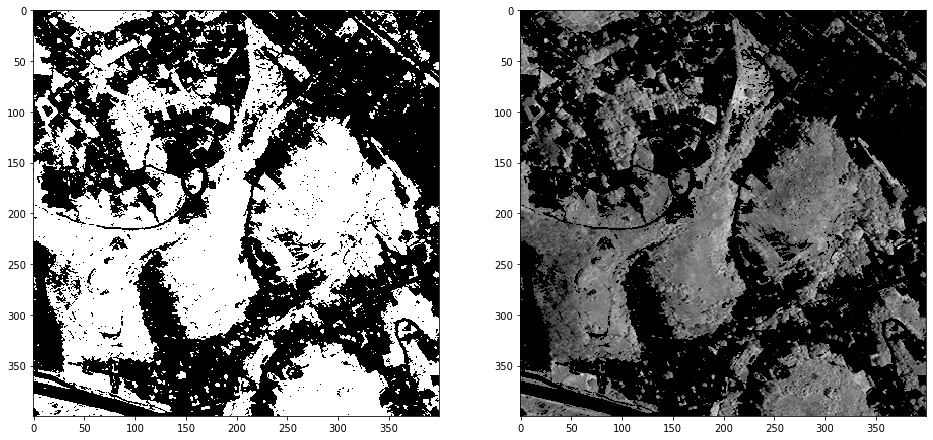

In [2]:
# abrir 2 imagens com 1 banda cada
filename_crop_1_band_5 = "./raster/crop-1-band-5.tif" # red
filename_crop_1_band_7 = "./raster/crop-1-band-7.tif" # nir

try:
    dataset_crop_1_band_5 = gdal.Open(filename_crop_1_band_5, GA_ReadOnly) 
    dataset_crop_1_band_7 = gdal.Open(filename_crop_1_band_7, GA_ReadOnly) 
except:
    print ("Erro na abertura de algum arquivo!")

# todas as imagens possuem uma banda cada
crop_1_band_5 = dataset_crop_1_band_5.GetRasterBand(1)
crop_1_band_7 = dataset_crop_1_band_7.GetRasterBand(1)

# para se realizar cálculos com as bandas, usamos a conversão para matriz numpy
numpy_crop_1_band_5 = crop_1_band_5.ReadAsArray().astype(float)
numpy_crop_1_band_7 = crop_1_band_7.ReadAsArray().astype(float)

# criar banda de índice de vegetação e aplicar fatiamento
threshold = 0.5
numpy_crop_1_ndvi = (numpy_crop_1_band_7 - numpy_crop_1_band_5) / \
                    (numpy_crop_1_band_7 + numpy_crop_1_band_5)
numpy_threshold = numpy_crop_1_ndvi > threshold
numpy_output = numpy_crop_1_band_7 * numpy_threshold

# visualização do resultado
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(numpy_threshold, cmap='gray')

plt.subplot(122)
plt.imshow(numpy_output, cmap='gray');

## Salvando um raster

Neste exemplo, vamos abrir duas bandas, realizar uma aritmética (NDVI) seguida de um fatiamento, e salvar o resultado num arquivo GeoTIFF. Para salvar um arquivo com imagens, é preciso criar um novo dataset, informar todos os metadados relacionados ao contexto geográfico (sistema de projeção, limite geográfico, etc.) além do número de bandas, número de linhas e colunas.

In [3]:
# obter metadados
linhas = dataset_crop_1_band_5.RasterYSize
colunas = dataset_crop_1_band_5.RasterXSize
bandas = 1

# salvar banda em arquivo GeoTIFF
# definir nome do arquivo
filename_output = "./raster/crop-1-ndvi-threshold.tif"
# definir driver
driver = gdal.GetDriverByName('GTiff')
# copiar tipo de dados da banda já existente
data_type = crop_1_band_5.DataType
# criar novo dataset
dataset_output = driver.Create(filename_output, colunas, linhas, bandas, data_type)
# copiar informações espaciais da banda já existente
dataset_output.SetGeoTransform(dataset_crop_1_band_5.GetGeoTransform())
# copiar informações de projeção
dataset_output.SetProjection(dataset_crop_1_band_5.GetProjectionRef())
# escrever dados da matriz NumPy na banda
dataset_output.GetRasterBand(1).WriteArray(numpy_output)
# salvar valores
dataset_output.FlushCache()
# fechar dataset
dataset_output = None

# Exercício

Criar uma função `salvar_banda` para salvar um raster de *uma banda*, tendo como parâmetros uma matriz NumPy com os pixels, o nome do arquivo GeoTIFF, e um dataset de referência (para copiar os metadados).

In [4]:
def salvar_banda(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    # obter metadados
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1
    # definir driver
    driver = gdal.GetDriverByName('GTiff')
    # copiar tipo de dados da banda já existente
    data_type = dataset_de_referencia.GetRasterBand(1).DataType
    # criar novo dataset
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type)
    # copiar informações espaciais da banda já existente
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform())
    # copiar informações de projeção
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef())
    # escrever dados da matriz NumPy na banda
    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels)
    # salvar valores
    dataset_output.FlushCache()
    # fechar dataset
    dataset_output = None

Obs.: para criar um raster com mais de uma banda, é preciso adaptar a função acima, nas chamadas as funções `driver.Create(...)` indicando o número de bandas correto, e também chamar N vezes a função `dataset_output.GetRasterBand(i).WriteArray(...)`.

## Exercício

Dados dois rasters de 1 banda cada (1 mapa temático, 1 mapa de referência), calcule a taxa de acerto da classificação do mapa temático e salve um arquivo GeoTIFF contendo um mapa de concordância entre as imagens.

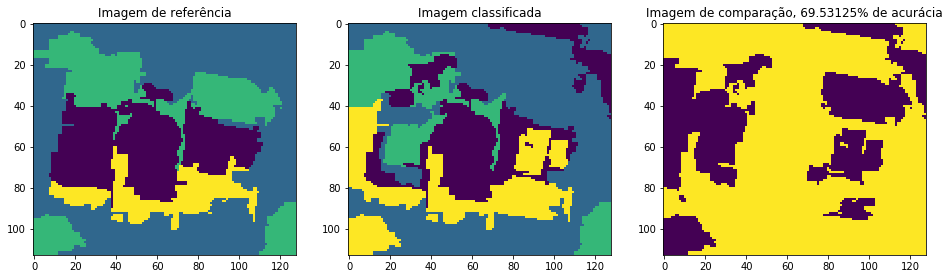

In [5]:
# abrir as imagens
filename_reference = "./raster/area_urbana_referencia.tif"
filename_classification = "./raster/area_urbana_classificacao.tif"

try:
    dataset_reference = gdal.Open(filename_reference, GA_ReadOnly) 
    dataset_classification = gdal.Open(filename_classification, GA_ReadOnly) 
except:
    print ("Erro na abertura de algum arquivo!")

# verificar compatibilidade de metadados
if (dataset_reference.GetProjectionRef() != dataset_classification.GetProjectionRef()):
    print("Sistemas de referência diferentes")
elif (dataset_reference.GetGeoTransform() != dataset_classification.GetGeoTransform()):
    print("Metadados espaciais diferentes")
else:
    # obter metadados
    linhas = dataset_reference.RasterYSize
    colunas = dataset_reference.RasterXSize

    # obter as bandas
    band_reference = dataset_reference.GetRasterBand(1)
    band_classification = dataset_classification.GetRasterBand(1)

    # gerar matrizes de pixels
    numpy_reference = band_reference.ReadAsArray()
    numpy_classification = band_classification.ReadAsArray()

    # gerar matriz de comparação
    numpy_comparison = (numpy_reference == numpy_classification)
    accuracy = 100 * numpy_comparison.sum() / (linhas * colunas)

    # plotar resultados
    plt.figure(figsize=(16, 8))

    plt.subplot(131)
    plt.imshow(numpy_reference)
    plt.title('Imagem de referência')

    plt.subplot(132)
    plt.imshow(numpy_classification)
    plt.title('Imagem classificada')

    plt.subplot(133)
    plt.imshow(numpy_comparison)
    plt.title('Imagem de comparação, ' + str(accuracy) + '% de acurácia');

    # salvar imagem de concordância
    nome_do_arquivo = "./raster/comparacao.tif"
    salvar_banda(numpy_comparison, nome_do_arquivo, dataset_reference)

# fechar imagens
dataset_reference = None
dataset_classification = None

## Exercício

Dadas 2 imagens (`raster_alvo` e `raster_entrada`), encontrar a localização da imagem `raster_alvo` dentro da imagem `raster_entrada` e plotar o resultado (`raster_entrada` com um `x` sobreposto na localização).

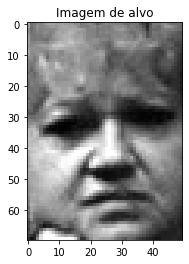

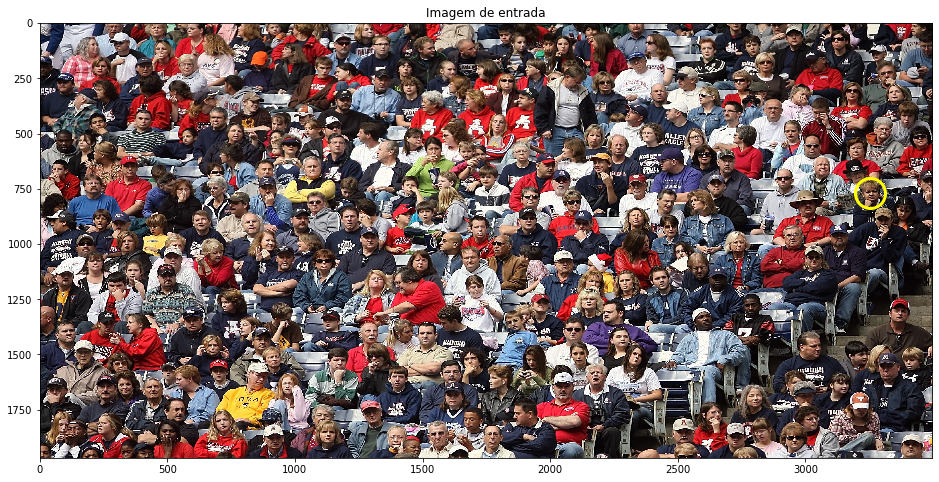

In [6]:
# definir onde estao as imagens
raster_entrada = './raster/american-anticipation-audience-163368.jpg'
raster_alvo = './raster/target_2.jpg'

# gerar datasets gdal
dataset_entrada = gdal.Open(raster_entrada, GA_ReadOnly)
dataset_alvo = gdal.Open(raster_alvo, GA_ReadOnly)

# obter as bandas
banda_entrada = dataset_entrada.GetRasterBand(1).ReadAsArray()
banda_alvo = dataset_alvo.GetRasterBand(1).ReadAsArray()

# obter metadados da imagem de entrada
Linhas_entrada = dataset_entrada.RasterYSize
Colunas_entrada = dataset_entrada.RasterXSize

# obter metadados da imagem de alvo
Linhas_alvo = dataset_alvo.RasterYSize
Colunas_alvo = dataset_alvo.RasterXSize

# encontrar linha/coluna do alvo na imagem de entrada
linha = 0
coluna = 0
# criar variável para armazenar a região de maior semelhança
maior_semelhanca = 0
for r in range(Linhas_entrada - Linhas_alvo):
    for c in range(Colunas_entrada - Colunas_alvo):
        # criar janela com recorte do mesmo tamanho da banda_alvo
        janela = banda_entrada[r:r+Linhas_alvo, c:c+Colunas_alvo]
        # comparar quantos pixels são iguais entre as duas janelas
        pixels_iguais = (banda_alvo == janela)
        somatorio = pixels_iguais.sum()
        if (somatorio > maior_semelhanca):
            linha = r
            coluna = c
            maior_semelhanca = somatorio

# apresentar resultado
plt.imshow(banda_alvo, cmap = 'gray')
plt.title('Imagem de alvo')

# obter as bandas em forma de array para visualização em cores
array_rgb = np.zeros((Linhas_entrada, Colunas_entrada, 3), dtype=np.uint8)
array_rgb[:,:,0] = dataset_entrada.GetRasterBand(1).ReadAsArray()
array_rgb[:,:,1] = dataset_entrada.GetRasterBand(2).ReadAsArray()
array_rgb[:,:,2] = dataset_entrada.GetRasterBand(3).ReadAsArray()

plt.figure(figsize=(16,8))
plt.imshow(array_rgb, aspect='auto')
plt.title('Imagem de entrada')
plt.plot(coluna+Colunas_alvo/2, linha+Linhas_alvo/2,
         marker='o', markersize=30, markeredgewidth=3, 
         markeredgecolor='yellow', markerfacecolor='none')

# fechar os arquivos
dataset_entrada = None
dataset_alvo = None